# Think Bayes

This notebook presents example code and exercise solutions for Think Bayes.

Copyright 2018 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import classes from thinkbayes2
from thinkbayes2 import Hist, Pmf, Suite, Beta
import thinkplot

import numpy as np

## Comparing distributions

Let's get back to the Kim Rhode problem from Chapter 4:

> At the 2016 Summer Olympics in the Women's Skeet event, Kim Rhode faced Wei Meng in the bronze medal match. They each hit 15 of 25 targets, sending the match into sudden death. In the first round, both hit 1 of 2 targets. In the next two rounds, they each hit 2 targets. Finally, in the fourth round, Rhode hit 2 and Wei hit 1, so Rhode won the bronze medal, making her the first Summer Olympian to win an individual medal at six consecutive summer games.

>But after all that shooting, what is the probability that Rhode is actually a better shooter than Wei? If the same match were held again, what is the probability that Rhode would win?

I'll start with a uniform distribution for `x`, the probability of hitting a target, but we should check whether the results are sensitive to that choice.

First I create a Beta distribution for each of the competitors, and update it with the results.

In [2]:
rhode = Beta(1, 1, label='Rhode')
rhode.Update((22, 11))

In [3]:
wei = Beta(1, 1, label='Wei')
wei.Update((21, 12))

Based on the data, the distribution for Rhode is slightly farther right than the distribution for Wei, but there is a lot of overlap.

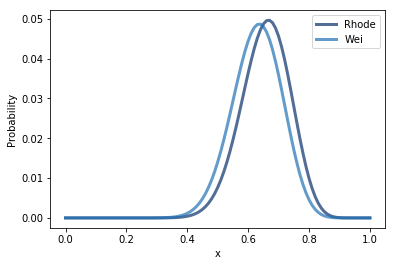

In [4]:
thinkplot.Pdf(rhode.MakePmf())
thinkplot.Pdf(wei.MakePmf())
thinkplot.Config(xlabel='x', ylabel='Probability')

To compute the probability that Rhode actually has a higher value of `p`, there are two options:

1. Sampling: we could draw random samples from the posterior distributions and compare them.

2. Enumeration: we could enumerate all possible pairs of values and add up the "probability of superiority".

I'll start with sampling.  The Beta object provides a method that draws a random value from a Beta distribution:

In [5]:
iters = 1000
count = 0
for _ in range(iters):
    x1 = rhode.Random()
    x2 = wei.Random()
    if x1 > x2:
        count += 1

count / iters

0.598

`Beta` also provides `Sample`, which returns a NumPy array, so we an perform the comparisons using array operations:

In [6]:
rhode_sample = rhode.Sample(iters)
wei_sample = wei.Sample(iters)
np.mean(rhode_sample > wei_sample)

0.579

The other option is to make `Pmf` objects that approximate the Beta distributions, and enumerate pairs of values:

In [7]:
def ProbGreater(pmf1, pmf2):
    total = 0
    for x1, prob1 in pmf1.Items():
        for x2, prob2 in pmf2.Items():
            if x1 > x2:
                total += prob1 * prob2
    return total

In [8]:
pmf1 = rhode.MakePmf(1001)
pmf2 = wei.MakePmf(1001)
ProbGreater(pmf1, pmf2)

0.5982856085975715

In [9]:
pmf1.ProbGreater(pmf2)

0.5982856085975715

In [10]:
pmf1.ProbLess(pmf2)

0.39831486726640597

**Exercise:** Run this analysis again with a different prior and see how much effect it has on the results.

## Simulation

To make predictions about a rematch, we have two options again:

1. Sampling.  For each simulated match, we draw a random value of `x` for each contestant, then simulate 25 shots and count hits.

2. Computing a mixture.  If we knew `x` exactly, the distribution of hits, `k`, would be binomial.  Since we don't know `x`, the distribution of `k` is a mixture of binomials with different values of `x`.

I'll do it by sampling first.

In [11]:
import random

def flip(p):
    return random.random() < p

`flip` returns True with probability `p` and False with probability `1-p`

Now we can simulate 1000 rematches and count wins and losses.

In [12]:
iters = 1000
wins = 0
losses = 0

for _ in range(iters):
    x1 = rhode.Random()
    x2 = wei.Random()
    
    count1 = count2 = 0
    for _ in range(25):
        if flip(x1):
            count1 += 1
        if flip(x2):
            count2 += 1
            
    if count1 > count2:
        wins += 1
    if count1 < count2:
        losses += 1
        
wins/iters, losses/iters

(0.52, 0.382)

Or, realizing that the distribution of `k` is binomial, we can simplify the code using NumPy:

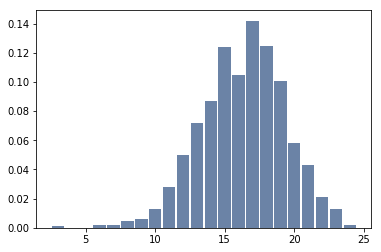

In [13]:
rhode_rematch = np.random.binomial(25, rhode_sample)
thinkplot.Hist(Pmf(rhode_rematch))

In [14]:
wei_rematch = np.random.binomial(25, wei_sample)
np.mean(rhode_rematch > wei_rematch)

0.509

In [15]:
np.mean(rhode_rematch < wei_rematch)

0.404

Alternatively, we can make a mixture that represents the distribution of `k`, taking into account our uncertainty about `x`:

In [16]:
from thinkbayes2 import MakeBinomialPmf

def MakeBinomialMix(pmf, label=''):
    mix = Pmf(label=label)
    for x, prob in pmf.Items():
        binom = MakeBinomialPmf(n=25, p=x)
        for k, p in binom.Items():
            mix[k] += prob * p
    return mix

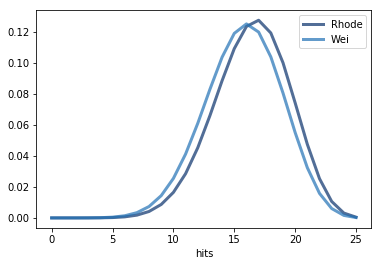

In [17]:
rhode_rematch = MakeBinomialMix(rhode.MakePmf(), label='Rhode')
wei_rematch = MakeBinomialMix(wei.MakePmf(), label='Wei')
thinkplot.Pdf(rhode_rematch)
thinkplot.Pdf(wei_rematch)
thinkplot.Config(xlabel='hits')

In [18]:
rhode_rematch.ProbGreater(wei_rematch), rhode_rematch.ProbLess(wei_rematch)

(0.5202329045554512, 0.3905260248840108)

Alternatively, we could use MakeMixture:

In [19]:
from thinkbayes2 import MakeMixture

def MakeBinomialMix2(pmf):
    binomials = Pmf()
    for x, prob in pmf.Items():
        binom = MakeBinomialPmf(n=25, p=x)
        binomials[binom] = prob
    return MakeMixture(binomials)

Here's how we use it.

In [20]:
rhode_rematch = MakeBinomialMix2(rhode.MakePmf())
wei_rematch = MakeBinomialMix2(wei.MakePmf())
rhode_rematch.ProbGreater(wei_rematch), rhode_rematch.ProbLess(wei_rematch)

(0.5202329045554512, 0.3905260248840108)

**Exercise:** Run this analysis again with a different prior and see how much effect it has on the results.

## Distributions of sums and differences

Suppose we want to know the total number of targets the two contestants will hit in a rematch.  There are two ways we might compute the distribution of this sum:

1. Sampling: We can draw samples from the distributions and add them up.

2. Enumeration: We can enumerate all possible pairs of values.

I'll start with sampling:

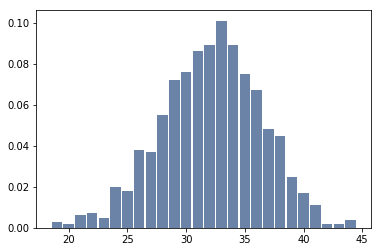

In [21]:
iters = 1000
pmf = Pmf()
for _ in range(iters):
    k = rhode_rematch.Random() + wei_rematch.Random()
    pmf[k] += 1
pmf.Normalize()
thinkplot.Hist(pmf)

Or we could use `Sample` and NumPy:

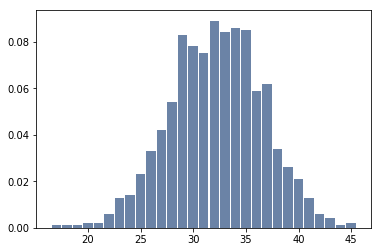

In [22]:
ks = rhode_rematch.Sample(iters) + wei_rematch.Sample(iters)
pmf = Pmf(ks)
thinkplot.Hist(pmf)

Alternatively, we could compute the distribution of the sum by enumeration:

In [23]:
def AddPmfs(pmf1, pmf2):
    pmf = Pmf()
    for v1, p1 in pmf1.Items():
        for v2, p2 in pmf2.Items():
            pmf[v1 + v2] += p1 * p2
    return pmf

Here's how it's used:

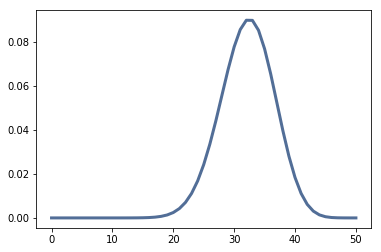

In [24]:
pmf = AddPmfs(rhode_rematch, wei_rematch)
thinkplot.Pdf(pmf)

The `Pmf` class provides a `+` operator that does the same thing.

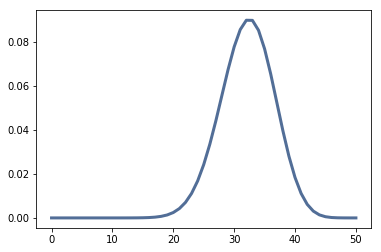

In [25]:
pmf = rhode_rematch + wei_rematch
thinkplot.Pdf(pmf)

**Exercise:**  The Pmf class also provides the `-` operator, which computes the distribution of the difference in values from two distributions.  Use the distributions from the previous section to compute the distribution of the differential between Rhode and Wei in a rematch.  On average, how many clays should we expect Rhode to win by?  What is the probability that Rhode wins by 10 or more?

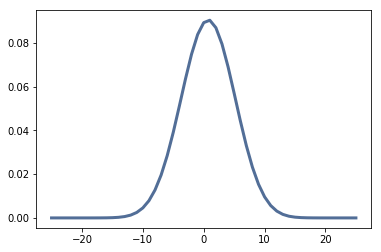

In [26]:
# Solution

pmf = rhode_rematch - wei_rematch
thinkplot.Pdf(pmf)

In [27]:
# Solution

# On average, we expect Rhode to win by about 1 clay.

pmf.Mean(), pmf.Median(), pmf.Mode()

(0.7142857142857105, 1, 1)

In [28]:
# Solution

# But there is, according to this model, a 2% chance that she could win by 10.

sum([p for (x, p) in pmf.Items() if x >= 10])

0.021355007938987394

## Distribution of maximum

Suppose Kim Rhode continues to compete in six more Olympics.  What should we expect her best result to be?

Once again, there are two ways we can compute the distribution of the maximum:

1. Sampling.

2. Analysis of the CDF.

Here's a simple version by sampling:

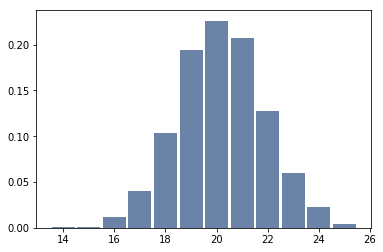

In [29]:
iters = 1000
pmf = Pmf()
for _ in range(iters):
    ks = rhode_rematch.Sample(6)
    pmf[max(ks)] += 1
pmf.Normalize()
thinkplot.Hist(pmf)

And here's a version using NumPy.  I'll generate an array with 6 rows and 10 columns:

In [30]:
iters = 1000
ks = rhode_rematch.Sample((6, iters))
ks

array([[19, 16, 14, ..., 22, 16, 12],
       [16, 14, 13, ..., 15, 17, 16],
       [14, 16, 20, ..., 21, 14, 22],
       [16, 18, 16, ..., 12, 16, 16],
       [16, 12, 16, ..., 15, 14, 14],
       [14, 10, 15, ..., 10, 15, 11]])

Compute the maximum in each column:

In [31]:
maxes = np.max(ks, axis=0)
maxes[:10]

array([19, 18, 20, 18, 22, 22, 20, 21, 21, 24])

And then plot the distribution of maximums:

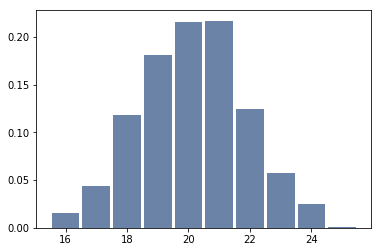

In [32]:
pmf = Pmf(maxes)
thinkplot.Hist(pmf)

Or we can figure it out analytically.  If the maximum is less-than-or-equal-to some value `k`, all 6 random selections must be less-than-or-equal-to `k`, so: 

$ CDF_{max}(x) = CDF(x)^6 $

`Pmf` provides a method that computes and returns this `Cdf`, so we can compute the distribution of the maximum like this:

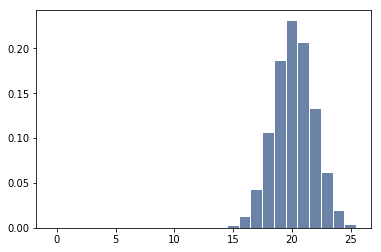

In [33]:
pmf = rhode_rematch.Max(6).MakePmf()
thinkplot.Hist(pmf)

**Exercise:**  Here's how Pmf.Max works:

    def Max(self, k):
        """Computes the CDF of the maximum of k selections from this dist.

        k: int

        returns: new Cdf
        """
        cdf = self.MakeCdf()
        cdf.ps **= k
        return cdf

Write a function that takes a Pmf and an integer `n` and returns a Pmf that represents the distribution of the minimum of `k` values drawn from the given Pmf.  Use your function to compute the distribution of the minimum score Kim Rhode would be expected to shoot in six competitions.

In [34]:
def Min(pmf, k):
    cdf = pmf.MakeCdf()
    cdf.ps = 1 - (1-cdf.ps)**k
    return cdf

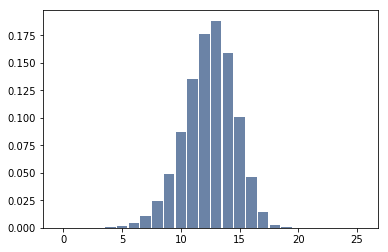

In [35]:
pmf = Min(rhode_rematch, 6).MakePmf()
thinkplot.Hist(pmf)